[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/knazari/Advanced_Robotic_2022/blob/main/Week5/AR_w5_ProMP_solution.ipynb)

In [ ]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import numpy.matlib as mat

**Probabilistic Movement Primitives**
===================================

In this notebook we will write a class called **ProMP** which includes all the information required to define a ProMP as well as important methods which allow the manipulation of the MPs to show the potential of the probabilistic approach.
<br/><br/>
_______________________________________________________________________________
<br/><br/>

For stroke-based movements, the mean of a ProMP is given by a weighted sum of $N$ Gaussians. These Gaussian basis functions have the following form:

\begin{equation}
b_i(t):=\mathrm{exp}\left(-\frac{(t-c_i)^2}{2h}\right),\;i=1,\ldots,N
\tag{1}
\end{equation}

These functions are commonly normalized to improve regression

\begin{equation}
\phi_i(t):=\frac{b_i(t)}{\sum_{j=1}^Nb_j(t)}
 \tag{2}
\end{equation}

The function $z(t)$ allows temporal modulation, so that our basis functions are given by:

\begin{equation}
\phi_i(z)=\phi_i(z(t))
 \tag{3}
\end{equation}

We work in discrete time, so we define a time step d$t$. By default, we work with a time lapse of 1s, therefore, if $T$ steps are needed, d$t=1/T$. We then introduce $\mathbf{\Phi}_t:=(\phi_1(t),\ldots,\phi_N(t))\in R^{N\times 1}$, which includes the evaluation of all basis functions in a time step.


The **BasisFuncGauss** function creates and evaluates $N$ basis Gaussian functions with a bandwidth $h$. Input $f$ refers to the linear modulation factor, so that the modulation is given by $z(t):=ft$. Then, the Gaussian functions $\phi_i(t)$ are evaluated as $\phi_i(ft)$. $dt$ represents the time step. The functions have modes at $c_i$, evenly spread along $[0,1/f]$. The output of this function is a $T\times N$array for which every row corresponds to the vector $\mathbf{\Phi}_t$ for every time step.
<br/><br/>

<font color='red'>In the code cell below, write instructions that will normalize the basis functions in $F$ in line 19 (use eq(2)).</font>

In [ ]:
def BasisFuncGauss(N, h, f, dt): 
    """
    Evaluates Gaussian basis functions in [0,1/f]
    N = number of basis functions
    h = bandwidth
    dt = time step
    f = modulation factor
    """
    tf = 1/f;
    T = int(round(tf/dt+1))
    Phi = np.zeros((T,N))
    for z in range(0,T):
        t = z*dt
        phi = np.zeros((1, N))
        for k in range(1,N+1):
            c = (k-1)/(N-1)
            phi[0,k-1] = np.exp(-(f*t - c)*(f*t - c)/(2*h))
        Phi[z,:N] = phi[0, :N]
    Phi = Phi/np.transpose(mat.repmat(np.sum(Phi,axis=1),N,1)); #[TxN]
    return Phi #[TxN]




In a ProMP, at time step $t$, a joint variable $q$ is modeled as:

\begin{equation}
q_t = \mathbf{\Phi}_t^{\mathrm{T}}\boldsymbol w + \epsilon_q
 \tag{4}
\end{equation} 


where $\epsilon_q$ adds zero-mean Gaussian observation noise with variance $\Sigma_q$. It follows that the probability of observing $q_t$ is represented by:


\begin{equation}
p(q_t|\boldsymbol w)=\mathcal{N}\left(q_t\,\big|\,\mathbf{\Phi}^{\mathrm{T}}_t\boldsymbol w, \mathbf{\Sigma}_q\right)
 \tag{5}
\end{equation}

Since $\Sigma_q$ is the same for every time step, the values $q_t$ are taken from independent and identical distributions, i.i.d. Hence, the probability of observing a trajectory $\tau:=\{q_1,\ldots,q_T\}$ is given by:

\begin{equation}
p(q_t|\boldsymbol w):=\prod_{t=1}^Tp(q_t|\boldsymbol w)
 \tag{6}
\end{equation}

However, since parameters $\boldsymbol w$ are to be learnt from data, we also assume such parameters are taken from a distribution $\boldsymbol w\sim p(\boldsymbol w|\theta)=\mathcal{N}(\boldsymbol w|\mu_{\boldsymbol w},\mathbf{\Sigma}_{\boldsymbol w})$. We therefore would like to have a predictive distribution of $q_t$ which does not depend on $\boldsymbol w$, but on $\theta:=(\mu_{\boldsymbol w},\mathbf{\Sigma}_{\boldsymbol w})$. This is done buy marginalizing $\boldsymbol w$ out in the distribution as follows:

\begin{equation}
p(q_t|\theta) = \int\mathcal{N}(q_t\,\big|\,\mathbf{\Phi}^{\mathrm{T}}_t\boldsymbol w,\,\Sigma_q)\mathcal{N}(\boldsymbol w\,\big|\,\mu_{\boldsymbol w},\,\Sigma_{\boldsymbol w})\mathrm{d}\boldsymbol w
 = \mathcal{N}(q_t\,\big|\,\mathbf{\Phi}^{\mathrm{T}}_t\boldsymbol w,\,\Sigma_q+\mathbf{\Phi}^{\mathrm{T}}_t\mathbf{\Sigma}_{\boldsymbol w}\mathbf{\Phi}_t)
  \tag{7}
\end{equation}


In the *ProMP* class, a *ProMP* object is initialized by the number of basis functions $N$, the bandwidth in the basis functions $h$, the time step d$t$, the covariance of the original distributions on $q$, *covQ* ($\Sigma_q$), the mean of the weights, $Wm$ ($\mu_{\boldsymbol w}$), and the covariance of the weights, *covW* ($\mathbf{\Sigma}_{\boldsymbol w}$). 
<br/><br/>
When initialized, the class also defines other convenience variables. *Phi* is the $T\times N$ matrix containing the basis functions evaluated for every time step and with a default modulation factor equal to 1; $Qm$ ($\mu_{q,t}$) is the mean values of $q$ for every time step; and *cov* is the covariance of the marginal distribution on $q$ for every time step.

<font color='red'>In the code cell below, write instructions that will calculate the covariance matrix $cov$  in line 13 (use eq(7)).</font>

In [ ]:
def __init__(self, N, h, dt, covQ, Wm, covW):
    self.N = N
    self.h = h
    self.dt = dt
    self.covQ = covQ
    self.Wm = Wm #[Nx1]
    self.covW = covW #[NxN]
    self.Phi = BasisFuncGauss(N,h,1,dt) #[TxN]
    self.T,_ = self.Phi.shape
    self.Qm = np.matmul(self.Phi,self.Wm) #[Tx1]
    self.cov = np.zeros((self.T,1)) #[Tx1]
    for i in range(0,self.T):
        self.cov[i,0] = self.covQ + np.matmul(np.array([self.Phi[i,:]]),np.matmul(covW,np.transpose(np.array([self.Phi[i,:]]))))

One of the big advantages of the ProMPs approach is the inclusion of new via-points. Say we wish to add a new via-point $q_{t^{*}}^{*}$ at time $t^{*}$ which is to be observed with an uncertainty of $\Sigma_{q^{*}}$. We simply have to obtain a posterior distribution over $\boldsymbol w$ by affecting our prior distribution with the new information given by $q_{t^{*}}^{*}$ and $\Sigma_{q^{*}}$. We thus apply Bayes theorem as follows:

\begin{equation}
p(\boldsymbol w|q_{t^{*}}^{*},\Sigma_{q^{*}})\propto\mathcal{N}\left(q_{t^{*}}^{*}\,\big|\,\mathbf{\Phi}^{\mathrm{T}}_{t^{*}}\boldsymbol w,\,\Sigma_{q^{*}}\right)p(\boldsymbol w)
 \tag{8}
\end{equation}

The result of applying the Bayes theorem leads to the following mean and variance of the posterior distribution:

\begin{equation}
\mu_{\boldsymbol w}^{[\mathrm{new}]} = \mu_{\boldsymbol w}+\mathbf{\Sigma}_{\boldsymbol w}\mathbf{\Phi}_{t^{*}}(\Sigma_q^{*}+\mathbf{\Phi}_{t^{*}}^{\mathrm{T}}\mathbf{\Sigma}_{\boldsymbol w}\mathbf{\Phi}_{t^{*}})^{-1}(q_{t^{*}}^{*}-\mathbf{\Phi}^{\mathrm{T}}_{t^{*}}\mu_{\boldsymbol w})
 \tag{9}
\end{equation}

\begin{equation}
\mathbf{\Sigma}_{\boldsymbol w}^{[\mathrm{new}]} = \mathbf{\Sigma}_{\boldsymbol w}-\mathbf{\Sigma}_{\boldsymbol w}\mathbf{\Phi}_{t^{*}}(\Sigma_q^{*}+\mathbf{\Phi}_{t^{*}}^{\mathrm{T}}\mathbf{\Sigma}_{\boldsymbol w}\mathbf{\Phi}_{t^{*}})^{-1}\mathbf{\Phi}_{t^{*}}^{\mathrm{T}}\mathbf{\Sigma}_{\boldsymbol w}
\end{equation}

The *condition* method conditions a ProMP to the new observation *Qstar* ($q^{*}_{t^{*}}$) at time *tstar* ($t^{*}$) with precision of observation *covQstar* ($\Sigma_{q^{*}}$).


<font color='red'>Complete the below code cell to compute *Wm* and *covW* follwing Eq. (9). Use variable *Phit* ($\Phi_{t^{*}}$) which is defined inside the function..</font>

In [ ]:
 def condition(self, tstar, Qstar, covQstar):
    Phit = np.transpose(self.Phi[tstar-1:tstar,:])
    self.Wm = self.Wm + np.matmul(self.covW,Phit)*1/(covQstar+np.matmul(np.transpose(Phit),np.matmul(self.covW,Phit)))*(Qstar-np.matmul(np.transpose(Phit),self.Wm))
    self.covW = self.covW - np.matmul(self.covW,Phit)*1/(covQstar+np.matmul(np.transpose(Phit),np.matmul(self.covW,Phit)))*np.matmul(np.transpose(Phit),self.covW)
    self.Qm = np.matmul(self.Phi,self.Wm)
    for i in range(0,self.T):
        self.cov[i,0] = self.covQ + np.matmul(np.array([self.Phi[i,:]]),np.matmul(self.covW,np.transpose(np.array([self.Phi[i,:]]))))

Temporal modulation is carried out by means of the previously defined phase function $z(t)$.

Member function *modulate* allows temporal modulation of a ProMP. Only linear time modulation is supported by this class. Modulation is given by the *factor* ($f$) input variable which is originally set to 1 when a ProMP is initialized. The phase function is then given by $z(t)=ft$. Note that $dt$ is constant throughout the code, hence, temporal modulation modifies $T$.

In [ ]:
 def modulate(self, factor):
    self.Phi = BasisFuncGauss(self.N,self.h,factor,self.dt) #[TxN]
    self.T,_ = self.Phi.shape # new T
    self.Qm = np.matmul(self.Phi,self.Wm) #[Tx1]
    self.cov = np.zeros((self.T,1)) #[Tx1]
    for i in range(0,self.T):
        self.cov[i,0] = self.covQ + np.matmul(np.array([self.Phi[i,:]]),np.matmul(self.covW,np.transpose(np.array([self.Phi[i,:]]))))

The *printMP* method inside the *ProMP* class plots the mean *Qm* ($\mu_q$) against time. It also plots two standard deviations above and below $\mu_q$ in order to show the marginal distribution at every time step. The *name* value refers to the title of the plot.

<font color='red'>To complete the code cell bellow, compute the $T\times 1$ arrays *upper* and *lower* which contain two standard deviations above and below the mean $\mu_q$, respectively, for every time step. Remember that we store the covariance at every time step in the member variable *cov*.</font>


In [ ]:
def printMP(self, name):
    t = np.arange(0, self.T*self.dt, self.dt)
    upper = self.Qm + 2*np.sqrt(self.cov)
    lower = self.Qm - 2*np.sqrt(self.cov)
    plt.plot(t,self.Qm)
    plt.fill_between(t, upper[:,0], lower[:,0], color = 'k', alpha = 0.1)
    plt.title(name)
    plt.show()

We would like to be able to blend different MPs into a single movement. For example, given two ProMPs, each having an important via-point, we wish to blend them so that our new ProMP crosses both via-points. We can do this by activation and deactivation of the ProMPs. We define the activation functions $\alpha^{[1]}(t)$ and $\alpha^{[2]}(t)$, with values $\alpha_{t}^{[1]}, \alpha_{t}^{[2]}\in[0,1]$ at each time step $t=1,\ldots,T$. When the value of an activation function reaches 0, the corresponding ProMP is fully deactivated. Oppositely, when the value reaches 1, the ProMP is fully activated. With these tools, the result of blending two ProMPs with predictive distributions $p^{[i]}(q_i)=\mathcal{N}(q_t\,|\,\mu_{q,t}^{[i]},\Sigma_t^{[i]})$, $i=1,2$ yields to a new ProMP described by $p^{*}(q_t)=\mathcal{N}(q_t\,|\,\mu_{q,t}^{*},\Sigma_t^{*})$, where:

\begin{equation}
\Sigma_t^{*} = (\frac{\alpha_t^{[1]}}{\Sigma_t^{[1]}} +\frac{\alpha_t^{[2]}}{\Sigma_t^{[2]}})^{-1}
 \tag{10}
\end{equation}

\begin{equation}
\mu_{q,t}^{*} = \Sigma_t^{*}(\frac{\alpha_t^{[1]}}{\Sigma_t^{[1]}}\mu_{q,t}^{[1]} + \frac{\alpha_t^{[2]}}{\Sigma_t^{[2]}}\mu_{q,t}^{[2]})
\end{equation}


The **blend** function blends two **ProMPs** objects, **MP1** and **MP2**, according to the activation functions **alpha1** ($\alpha_t^{[1]}$) and **alpha2** ($\alpha_t^{[2]}$). Vectors **alpha1** and **alpha2** contain the values of the activation functions for every time step. It is assumed that both ProMPs have the same value for **T**, hence, **alpha1** and **alpha2** must be arrays of **T** elements.


<font color='red'>Using Eq. (10), complete the code above by writing the expressions for $cov12$ and $Qm12$, which correspond to the covariance $\Sigma_t^{*}$ and mean $\mu_{q,t}^{*}$ of the resulting ProMP at every time step. In order to be compatible with the $ProMP$ class,$cov12$ and $Qm12$ must be arrays with shapes $(T,1)$.</font>


In [ ]:
def blend(MP1,MP2,alpha1,alpha2):
    """
    blends two MPs
        MP1, MP2 = ProMP objects to blend
        alpha1, alpha2 = activation functions for each respective MP [Tx1]
    """
    a1 = np.transpose(np.array([alpha1])) #[Tx1]
    a2 = np.transpose(np.array([alpha2])) #[Tx1]
    cov12 = (a1*(MP1.cov**-1) + a2*(MP2.cov**-1))**-1
    Qm12 = (cov12)*(a1*(MP1.cov**-1)*MP1.Qm + a2*(MP2.cov**-1)*MP2.Qm)
    M12 = ProMP(MP1.N,MP1.h,MP1.dt,MP1.covQ,np.zeros((MP1.N,1)),np.zeros((MP1.N,MP1.N)))
    M12.cov = cov12
    M12.Qm = Qm12
    return M12

Now that we defined the methods we can define ProMP class. Replace your written method in the corresponding section.

In [ ]:
class ProMP:
    """
    ProMP class
        N = number of basis functions
        h = bandwidth of basis functions
        dt = time step
        covQ = variance of original p(Q)
        Wm = mean of weights [Nx1]
        covW = variance of weights [NxN]
    internal:
        Phi = basis functions evaluated for every step [TxN]
        Qm = mean of Q [Nx1]
        cov = variance of p(Q|Wm) for every step  [Tx1]
    methods:
        condition (conditions an MP for a new viapoint)
            tstar = step of viapoint
            Qstar = value of Q of the viapoint
            covTstar = uncertainty of observation
        modulate (linear time modulation of the MP)
            factor = factor of linear modulation, z = factor*t
        printMP (plots an MP showing a standar deviation above and below)
            name = title of the plot
    """
    def __init__(self, N, h, dt, covQ, Wm, covW):
        self.N = N
        self.h = h
        self.dt = dt
        self.covQ = covQ
        self.Wm = Wm #[Nx1]
        self.covW = covW #[NxN]
        self.Phi = BasisFuncGauss(N,h,1,dt) #[TxN]
        self.T,_ = self.Phi.shape
        self.Qm = np.matmul(self.Phi,self.Wm) #[Tx1]
        self.cov = np.zeros((self.T,1)) #[Tx1]
        for i in range(0,self.T):
            self.cov[i,0] = self.covQ + np.matmul(np.array([self.Phi[i,:]]),np.matmul(covW,np.transpose(np.array([self.Phi[i,:]]))))
    def condition(self, tstar, Qstar, covQstar):
        Phit = np.transpose(self.Phi[tstar-1:tstar,:])
        self.Wm = self.Wm + np.matmul(self.covW,Phit)*1/(covQstar+np.matmul(np.transpose(Phit),np.matmul(self.covW,Phit)))*(Qstar-np.matmul(np.transpose(Phit),self.Wm))
        self.covW = self.covW - np.matmul(self.covW,Phit)*1/(covQstar+np.matmul(np.transpose(Phit),np.matmul(self.covW,Phit)))*np.matmul(np.transpose(Phit),self.covW)
        self.Qm = np.matmul(self.Phi,self.Wm)
        for i in range(0,self.T):
            self.cov[i,0] = self.covQ + np.matmul(np.array([self.Phi[i,:]]),np.matmul(self.covW,np.transpose(np.array([self.Phi[i,:]]))))
    def modulate(self, factor):
        self.Phi = BasisFuncGauss(self.N,self.h,factor,self.dt) #[TxN]
        self.T,_ = self.Phi.shape # new T
        self.Qm = np.matmul(self.Phi,self.Wm) #[Tx1]
        self.cov = np.zeros((self.T,1)) #[Tx1]
        for i in range(0,self.T):
            self.cov[i,0] = self.covQ + np.matmul(np.array([self.Phi[i,:]]),np.matmul(self.covW,np.transpose(np.array([self.Phi[i,:]]))))
    def printMP(self, name):
        t = np.arange(0, self.T*self.dt, self.dt)
        upper = self.Qm + 2*np.sqrt(self.cov)
        lower = self.Qm - 2*np.sqrt(self.cov)
        plt.plot(t,self.Qm)
        plt.fill_between(t, upper[:,0], lower[:,0], color = 'k', alpha = 0.1)
        plt.title(name)
        plt.show()

Now we will use the samples of weights $\boldsymbol w$ obtained in 5 observations. So we assume that the learning process has been completed. With this data, a ProMP for a single joint variable $q$ is created. We will carry out the following experiments:

*   Condition the ProMP to a first via-point
*   Condition the resulting ProMP from the previous experiment to a second via-point

*   Obtain two ProMPs after conditioning the original MP to each via-point, separately, and blend the two results
*   Time-modulate the original ProMP to different phases






Array $Wsamples$ includes the values of the $N = 15$ weights after 5 observations. $\mu_{\boldsymbol w}$ is computed from these observations and stored in $Wmean$. Similarly, $\mathbf{\Sigma}_{\boldsymbol w}$ is saved in $Wcov$. Using these values, three identical objects of the class $ProMP$ are defined.


In [ ]:
 # 15 weights obtained from 5 observations
Wsamples = np.array([[0.0141,0.0130,0.0038,0.0029,0.0143],
                      [0.0044,0.2025,0.0178,0.0703,0.0143],
                      [0.0388,0.1042,0.0531,0.0854,0.1479],
                      [0.0025,0.0321,0.0235,0.0495,0.0086],
                      [0.0810,0.0178,0.1500,0.0310,0.0843],
                      [0.0658,0.1258,0.0488,0.1650,0.1398],
                      [0.1059,0.0821,0.0116,0.2260,0.0531],
                      [0.0032,0.0952,0.0305,0.2220,0.0025],
                      [0.2031,0.1665,0.1430,0.0842,0.0656],
                      [0.0491,0.1543,0.1232,0.1505,0.0049],
                      [0.1914,0.0525,0.0783,0.0009,0.0292],
                      [0.0584,0.1035,0.0830,0.0305,0.1452],
                      [0.0157,0.1713,0.2550,0.0695,0.0051],
                      [0.2106,0.0630,0.0942,0.0086,0.1512],
                      [0.0959,0.2093,0.1388,0.0566,0.0819]])

Wmean = np.transpose([np.mean(Wsamples, axis=1)])
Wcov = np.cov(Wsamples)
N,_ = Wsamples.shape

T = 100
dt = 1/(T-1)

# Define MPs
MP1 = ProMP(N,0.02,dt,1e-6,Wmean,Wcov)
MP2 = ProMP(N,0.02,dt,1e-6,Wmean,Wcov)
MP3 = ProMP(N,0.02,dt,1e-6,Wmean,Wcov)

$MP2$ is conditioned to point $Qstar1$, at time step $T$, with an uncertainty of the observation equal to $covQstar1$. The desired via-point, the original mean and the new conditioned mean are then plotted.

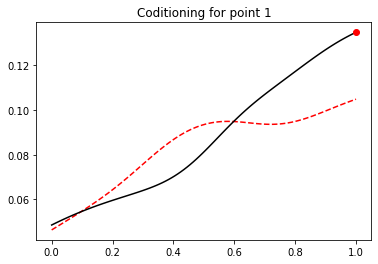

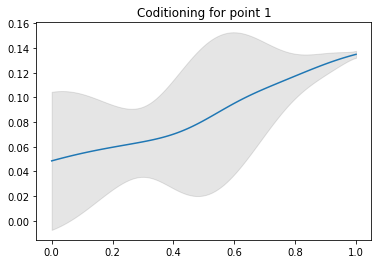

In [ ]:
# New desired point
tstar1 = 100
Qstar1 = MP2.Qm[100-1]+ 0.03
covQstar1 = 1e-6
MP2.condition(tstar1,Qstar1,covQstar1)

t = np.arange(0, 1+dt, dt)

# Plot original mean, and mean of conditioned MP
plt.figure()
plt.plot(t,MP1.Qm, 'r--', t, MP2.Qm, 'k')
plt.plot(tstar1/(MP1.T), Qstar1,'ro')
plt.title('Coditioning for point 1')
plt.show()

# Print MP conditioned to point 1
MP2.printMP('Coditioning for point 1')

The resulting MP is now conditioned to a second via-point, $Qstar2$, at time step $tstar2$. The resulting ProMP must cross both points.

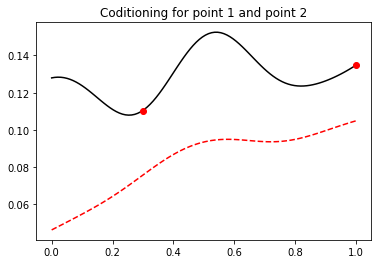

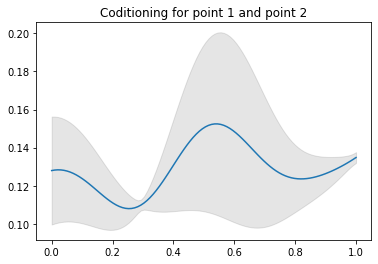

In [ ]:
# Second desired point
tstar2 = 30
Qstar2 = 0.11
covQstar2 = 1e-6
MP2.condition(tstar2,Qstar2,covQstar2)

plt.figure()
plt.plot(t,MP1.Qm, 'r--', t, MP2.Qm, 'k')
plt.plot(tstar1/(MP1.T), Qstar1,'ro')
plt.plot(tstar2/(MP1.T), Qstar2,'ro')
plt.title('Coditioning for point 1 and point 2')
plt.show()

MP2.printMP('Coditioning for point 1 and point 2')


MPs $MP1$ and $MP2$ are conditioned to points 1 and 2, respectively. Then both are blended. The result of the blending must have both points as via-points. 

<font color='red'>To complete the code, come up with an expression for the $T-$element array ***alpha1*** which contains the values $\alpha_t^{[1]}$ of the activation function for MP **MP1**. Since tstar1 = 100 and tstar2 = 30, $\alpha_t^{[1]}$ must be equal (or close) to 1 at $t = 100$ but must be equal (or close) to 0 at $t = 30$, and there must be a smooth transition between these values. $\alpha_t^{[2]}$ is simply computed by \texttt{alpha2 = -alpha1+1} in the following line of the code.

For this, find suitable values for $A$, $B$ and $C$ in the following function:
\begin{equation}
\alpha^{[1]}(t):=A\mathrm{tanh}\left(B\left(\frac{t-C}{T}\right)\right)+A
\end{equation}
The figure below shows an example of such a function using $B=30$, but you can play with this value and see how it affects the result. 
</font>

![picture](https://drive.google.com/uc?export=view&id=1ioYegmxoeemojtbuAtIMNsA43IBXaNIT)


The program then plots the ProMPs with the following results:

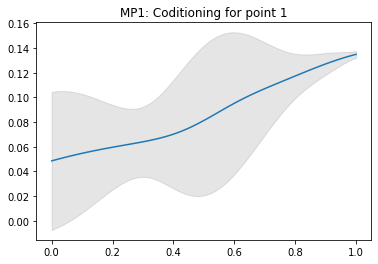

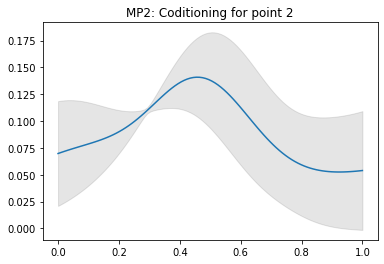

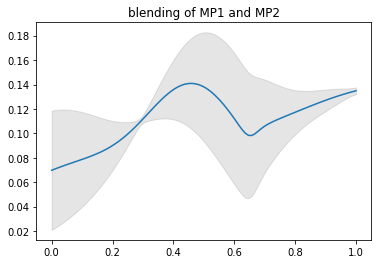

In [ ]:
# Blending: MP1 is conditioned to point 1, MP2 is conditioned to point 2, MP12 is the result of blending both
MP1 = ProMP(N,0.02,dt,1e-6,Wmean,Wcov)
MP2 = ProMP(N,0.02,dt,1e-6,Wmean,Wcov)
MP1.condition(tstar1,Qstar1,covQstar1)
MP2.condition(tstar2,Qstar2,covQstar2)
MP1.printMP('MP1: Coditioning for point 1')
MP2.printMP('MP2: Coditioning for point 2')
# Activation functions for blending
alpha1 = 0.5*np.tanh(30*(np.arange(0,MP1.T)/(MP1.T)-65/(MP1.T)))+0.5
alpha2 = -alpha1+1
MP12 = blend(MP1,MP2,alpha1,alpha2)
MP12.printMP('blending of MP1 and MP2')

Given three initially identical MPs, MP1, MP2 and MP3, MP2 is modulated with a factor of 0.75, i.e. $z(t)=0.75t$, and MP3 with a factor 1.5, i.e. $z(t)=1.5t$. MP1 is left unmodified. 

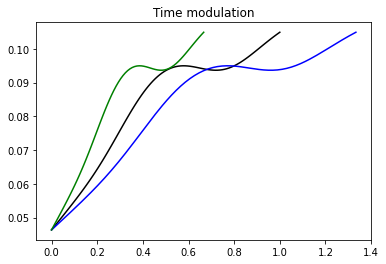

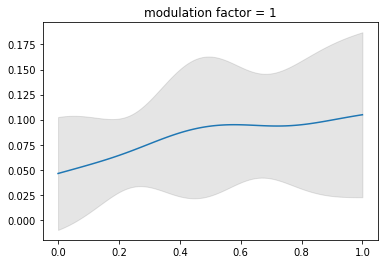

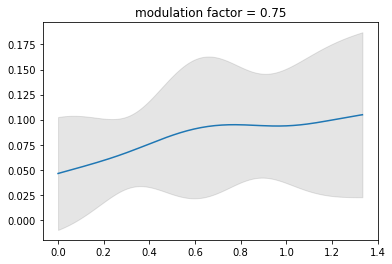

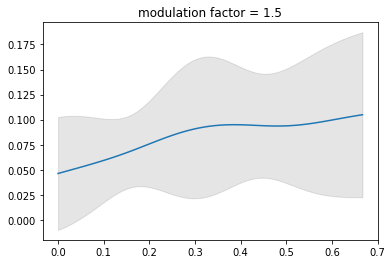

In [ ]:
#time modulation
MP1 = ProMP(N,0.02,dt,1e-6,Wmean,Wcov)
MP2 = ProMP(N,0.02,dt,1e-6,Wmean,Wcov)
MP3 = ProMP(N,0.02,dt,1e-6,Wmean,Wcov)
MP2.modulate(0.75)
MP3.modulate(1.5)

t1 = np.arange(0, MP1.T*dt, dt)
t2 = np.arange(0, MP2.T*dt, dt)
t3 = np.arange(0, MP3.T*dt, dt)

# Plot original mean, and mean of conditioned MP
plt.figure()
plt.plot(t1,MP1.Qm, 'k')
plt.plot(t2,MP2.Qm, 'b')
plt.plot(t3,MP3.Qm, 'g')
plt.title('Time modulation')
plt.show()

MP1.printMP('modulation factor = 1')
MP2.printMP('modulation factor = 0.75')
MP3.printMP('modulation factor = 1.5')